# EE4211 Group Project

### Members of Group 16 (by Alphabet) ###
+ **Feng Xijia**,  A0232695X, e0724494@u.nus.edu
+ **Liang Zihan**, A0232558B, e0724357@u.nus.edu
+ **Tan Tian**,   A0229561B, e0679994@u.nus.edu
+ **Yao Yuan**,   A0232893X, e0724692@u.nus.edu

<font color=##008B8B > Remark: </font>
The entire program takes about **12** minutes to run.

---

# <font color=##008B8B > Question 2    Forecasting </font>

## <font color=##008B8B > Question 2.1 </font>

**<font color=##008B8B >In this part, you will be asked to build a model to forecast the hourly readings in the future (next hour). Can you explain why you may want to forecast the gas consumption in the future? Who would find this information valuable? What can you do if you have a good forecasting model?</font>**

The predictions of gas consumption can be quite useful. For overall predictions, the gas company can allocate equipment, workforce, and supply amount in advance to cope with possible rush to prevent breakdowns. During the low consumption period, operation tasks can be assigned to only a fraction of the facilities to save energy and run daily check on other equipment. Besides, the power company may reduce the sampling frequencies from meters during low consumption periods so as to lighten the load of MDMS.  
With proper forecasting, the gas company can be better prepared to provide a stable gas supply, and the burden of MDMS will be alleviated. This will lead to a minimized resource waste and a better environment.

---

## <font color=##008B8B > Question 2.2</font>

**<font color=##008B8B >Build a linear regression model to forecast the hourly readings in the future (next hour). Generate two plots:  
 i) Time series plot of the actual and predicted hourly
meter readings and   
ii) Scatter plot of actual vs predicted meter readings (along with the line showing how good the fit is).</font>**

#### Data reading and preprocessing

In [1]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas import DataFrame
from datetime import date
import datetime
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
df['localminute'] = df['localminute'].astype(str).str[:19]
df['localminute'] = pd.to_datetime(df['localminute'])
warnings.filterwarnings("ignore")
print(df.head(5))

          localminute  dataid  meter_value
0 2015-10-01 00:00:10     739        88858
1 2015-10-01 00:00:13    8890       197164
2 2015-10-01 00:00:20    6910       179118
3 2015-10-01 00:00:22    3635       151318
4 2015-10-01 00:00:22    1507       390354


In [3]:
def get_value_ID(ID):

    '''
    Plot all the hourly meter readings of the indicated user.
    
    Parameters: 
    ID: The ID of user of interest.
    
    return DataFormat.
    
    '''
    #create a new dataframe df1 to store the hourly value of one ID
    df1 = pd.DataFrame(columns=['time','value'])
    # Format
    # time：year-month-day-hour  value: readings
    group_ID=df.groupby(["dataid"])
    group=group_ID.get_group(ID)
    value_group=group["meter_value"]
    value=value_group.tolist()
    time_group=group["localminute"]
    time_group=pd.to_datetime(time_group)
    year=time_group.dt.year.tolist()
    month=time_group.dt.month.tolist()
    day=time_group.dt.day.tolist()
    hour=time_group.dt.hour.tolist()
    datelist=list(zip(year,month,day,hour))
    datelist=[[str(di) for di in d] for d in datelist]# convert to str, otherwise cannot use join()
    datelist=['-'.join(d) for d in datelist]# Year-month-day-hour
    month_has_readings = []
    for i in range(len(datelist)):
        if i ==0:
            df1 = df1.append({'time':datelist[i],'value':value[i]},ignore_index=True)
            month_has_readings.append(month[i])
        elif (datelist[i] != datelist[i-1]) and (0 <=value[i] - value[i-1]<500): # Those in Dataframe must have different timestamp without abnormal data(no jumps over 500, no decreasing)
            df1 = df1.append({'time':datelist[i],'value':value[i]},ignore_index=True)
            if month[i] != month[i-1]:
                month_has_readings.append(month[i])
#    print("Meter_Id is:"+str(ID)+", Months have readings:")
#    print(month_has_readings)
    return df1

#### For example id = 9982, by using above function, all hour readings for 9982 is stored in dataframe

In [4]:
get_value_ID(9982)

,time,value
0,2015-10-1-1,105946
1,2015-10-1-5,105946
2,2015-10-1-8,105960
3,2015-10-1-9,105960
4,2015-10-1-13,105962
...,...,...
1204,2016-3-28-9,119734
1205,2016-3-28-11,119736
1206,2016-3-29-4,119784
1207,2016-3-30-17,119852


**Among all the user data, some households have abnormal gas values. Therefore, we divide the meters into two parts.**  
1. **Normal meters**, which have no long period of missing data  
2. **Long interval meters**, which have long pieces data missing

### 2.2.1 Normal meters

**Use linear regression to predict the future readings.**

In [5]:
def value_prediction_lr(ID,test_size):
        
    '''
    Purpose:
        - Using linear regression to predict the readings.
        - Plot the actual and predicted readings in time series.
        - Plot the true vs predicted scatter readings.
    
    Parameters:
        - ID: The user you would like to evaluate.
        - test_size: The proportion of test set you want to set.
    
    '''
    
    df1=get_value_ID(ID)
    X=DataFrame(df1.index)
    date=df1["time"]
    y=df1["value"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False) # Set shuffle=False.
    split_date=df1["time"][len(X_train)-1] # Train test split date
    ymin=df1["value"].min()
    ymax=df1["value"].max()
    
    model = LinearRegression().fit(X_train,y_train)
    y_pred = model.predict(X)
    score_train=model.score(X_train,y_train)
    score_test=model.score(X_test,y_test)
    print('Coefficient of determination of the training set is',score_train)
    print('Coefficient of determination of the test set is',score_test)
    
    # Plot the true and predicted readings in time series
    plt.rcParams['figure.figsize']=(20,5)
    plt.rcParams['savefig.dpi']=200
    plt.rcParams['figure.dpi']=200
    ax=plt.gca()
    x_major_locator=MultipleLocator(len(X)/10)
    ax.xaxis.set_major_locator(x_major_locator)
    plt.plot(X.values.tolist(), y,'o',markersize=1) # Don't use scatter, otherwise it won't show a complete figure when plotted with 'plt.plot' 
    plt.plot(date, y_pred,'o',markersize=1,c='#ff7f0e')
    plt.vlines(split_date,ymin,ymax,linestyles="dotted",color="k") # Split line
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True and Predicted Readings in time series (Linear Regression)')
    plt.savefig("True and Predicted Readings in time series (Linear Regression).jpg")
    plt.show()
    
    # Plot the true vs predicted readings
    plt.rcParams['figure.figsize']=(10,10)
    plt.rcParams['savefig.dpi']=100
    plt.rcParams['figure.dpi']=100
    plt.plot(y,y_pred,'o',markersize=1,label='True vs Predicted')
    plt.plot(y,y,markersize=1,c='#ff7f0e',label='Reference Line')
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title('True vs Predicted Meter Readings (Linear Regression)')
    plt.savefig("True vs Predicted Meter Readings (Linear Regression).jpg")
    plt.legend()
    plt.show()

Coefficient of determination of the training set is 0.9623108258043813
Coefficient of determination of the test set is -1.3721329885826852


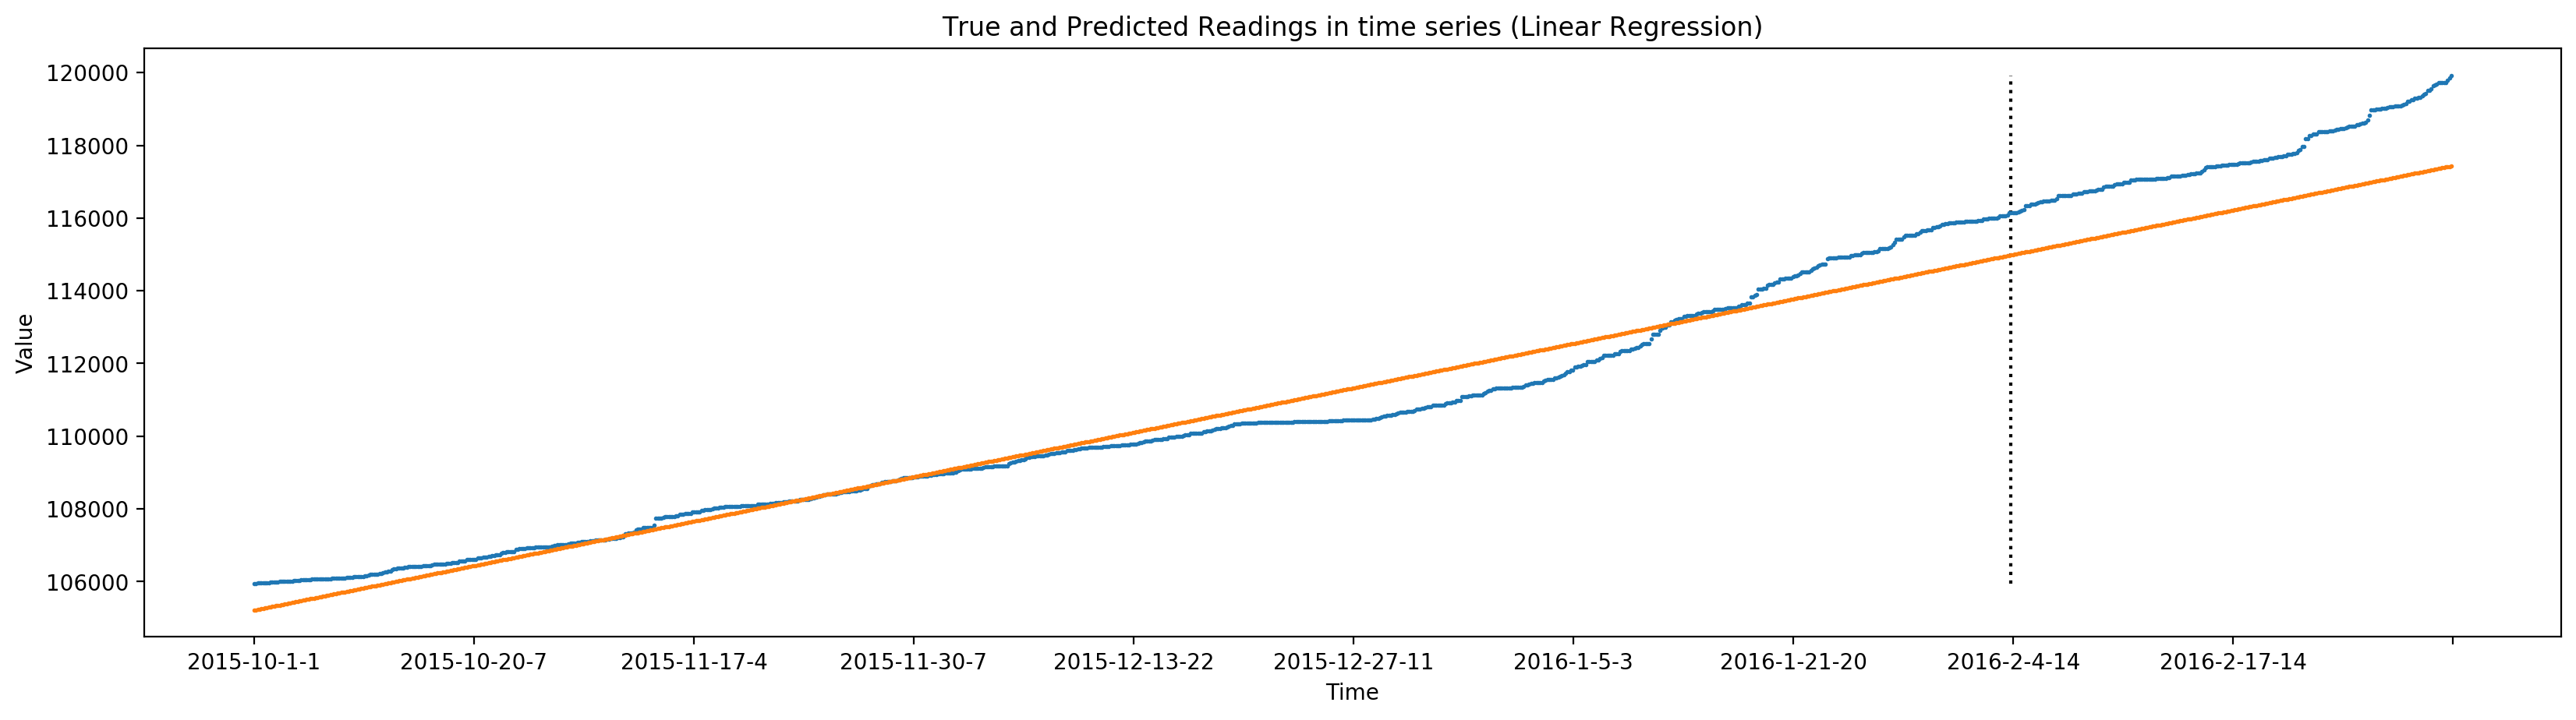

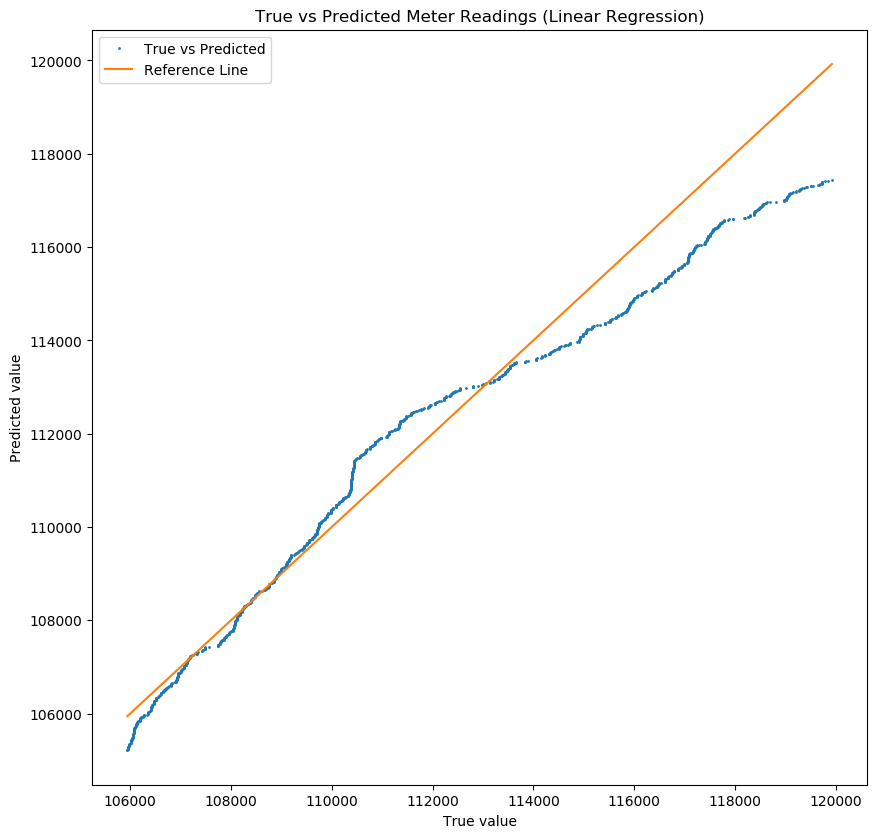

In [6]:
value_prediction_lr(9982,0.2)

### 2.2.2 Long interval meters

**According to Q1, some meters have long intervals.**   
+ The ID of malfunctioning meters which have long intervals is 17.    
+ The ID of all the malfunctioning meters are: 2233, 2638, 2645, 3039, 4352, 4421, 4447, 4671, 4874, 6685, 6863,7460, 7919, 8467, 8703, 9474, 9620.  
+ Three meters (4874,8703,9620) were abandoned because the amount of data they have are too small.

**Therefore, we need to find a proper way to analyse these data better. Three ways are listed below:**
1. Stay the way it is <br>
2. If a particular hour has no reading, use the reading of the previous hour as the reading of this hour<br>
3. If a particular hour has no reading, use the average readings of the previous hour and next hour as the reading of this hour<br>

- **Method 1: Stay the way it is**  

Polynomial regression can be represented in linear regression way. Therefore, we can find the best degree of fitting first.

In [7]:
values_hourly_dict1 = {} #Store the hourly reading of every meterID below
meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
for key in meter_IDs:
    values_hourly = get_value_ID(key)
    values_hourly_dict1[key] = values_hourly

In [8]:
# Use different degree of Linear Regression to find which degree is fit best
def get_meanScore_of_LR(degree=1):
    scorelist = []
    score_all= 0
    #  4874,8703,9620 have incomplete training or test set, the score of 4671 cannot be computed
    meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
    for key in meter_IDs:
        values_hourly = values_hourly_dict1.get(key)
        values_hourly['index'] = (pd.to_datetime(values_hourly['time'], format='%Y-%m-%d-%H') - pd.to_datetime('2015-10-1')) / pd.Timedelta(hours=1)
        X = values_hourly['index'].values.reshape(-1, 1)
        y = values_hourly['value'].values.reshape(-1, 1)
        # Set shuffle=False. Train:Test=7:3
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        
        if degree == 1:
            Linreg = LinearRegression().fit(X_train, y_train)
            score = Linreg.score(X_test, y_test)
        else:
            quadratic_featurizer = PolynomialFeatures(degree)
            X_train_quadratic = quadratic_featurizer.fit_transform(X_train)
            X_test_quadratic = quadratic_featurizer.transform(X_test)
            regressor_quadratic = LinearRegression().fit(X_train_quadratic, y_train)
            regressor_quadratic.fit(X_train_quadratic, y_train)
            score = regressor_quadratic.score(X_test_quadratic, y_test)

        score_all = score_all + score
        scorelist.append(round(score,4))
    score_mean = score_all / len(meter_IDs)
#     print('Degree is :'+ str(degree)+', Score_Mean is:'+ str(score_mean)+', ScoreList is: ',scorelist,'\n')
    print('Degree: %s, mean score: %.4f, score list: %s'%(degree,score_mean,scorelist))
    return score_mean

Degree: 1, mean score: -9.5917, score list: [-2.3775, -8.2351, -103.9374, 0.3951, -1.0105, -0.3841, 0.5095, -0.533, -0.7097, -0.8712, -0.2071, 0.3434, -7.6746]
Degree: 2, mean score: -43.0152, score list: [-147.5867, -98.8594, -103.944, -33.1639, 0.595, -71.9828, -9.5875, -6.5567, 0.1855, -16.427, -41.7448, -1.6917, -28.4335]
Degree: 3, mean score: -25.7053, score list: [-31.1631, -76.0304, -12.9688, -20.8043, -18.7979, -31.044, -0.531, 0.8429, 0.8041, -6.3004, -14.0496, -85.1801, -38.9457]
Degree: 4, mean score: -1366.4777, score list: [-168.5501, -28.5069, -28.5061, -6.7787, -1026.0605, -62.3141, -39.8976, -20.7438, -16323.0012, -9.3202, -29.4686, -21.3351, 0.2728]


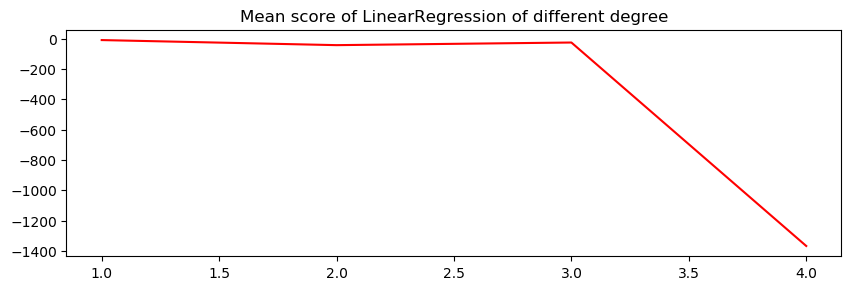

In [9]:
scores_by_degree = []
for i in range(4):
    score = get_meanScore_of_LR(i+1)
    scores_by_degree.append(score)
plt.rcParams['figure.figsize'] = (10.0, 3.0)
plt.plot([1,2,3,4], scores_by_degree,color='r')
plt.title("Mean score of LinearRegression of different degree")
plt.show()

**According to the figure above, the best score achieves when the degree equals 1, so we will use one order linear regression to fit the data.**

In [10]:
def LR_Method1(ID):
    values_hourly = get_value_ID(ID)
    values_hourly['index'] = (pd.to_datetime(values_hourly['time'], format='%Y-%m-%d-%H') - pd.to_datetime('2015-10-1')) / pd.Timedelta(hours=1)
    X_all = values_hourly['index'].values.reshape(-1, 1)
    y_all = values_hourly['value'].values.reshape(-1, 1)
    # Set shuffle=False. Train:Test=7:3
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, shuffle=False)
    Linreg = LinearRegression().fit(X_train, y_train)
    y_predict = Linreg.predict(X_test.reshape(-1, 1))

    # Time series plot of the actual and predicted hourly meter readings
    plt.rcParams['figure.figsize'] = (20.0, 6.0)
    plt.plot(X_all, Linreg.predict(X_all),color='r')
    plt.axvline(X_train[-1], color='black', linestyle='--')
    plt.scatter(X_train, y_train, color='b', s=2)
    plt.scatter(X_test, y_test, color='g', s=2)
    plt.title("Meter ID {} LinearRegression Predict Value and Actual Hourly Reading".format(ID))
    plt.tight_layout()
    plt.legend(["LR Fitting Line", "Boundary of Train set and test set", 'train data', 'test data'])
    plt.show()
    
    #  Scatter plot of actual vs predicted meter readings
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    left_interval = min(y_test[0], y_predict[0])[0]
    right_interval = max(y_test[-1], y_predict[-1])
    plt.axis([left_interval, right_interval, left_interval, right_interval])
    plt.plot(range(int(right_interval)), range(int(right_interval)),color='r') # 45 degree line
    plt.plot(y_test, y_predict,'o',markersize=1) # X-axis is actual value
    plt.legend(["Line y=x", "actual vs predicted meter readings"])
    plt.xlabel('Actual Reading')
    plt.ylabel('Predict Reading')
    plt.title('Actual vs Predicted meter readings')
    plt.show()

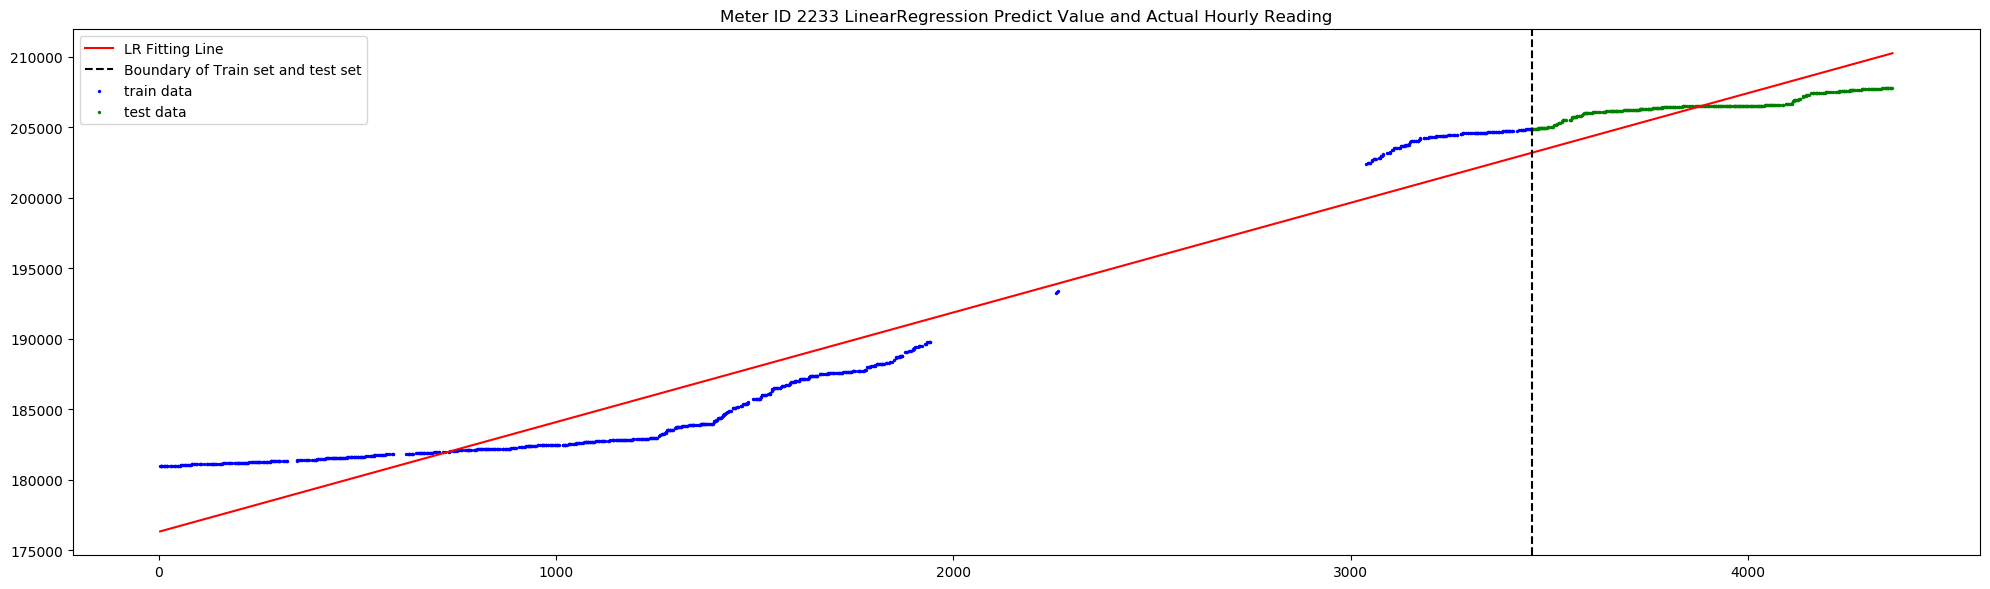

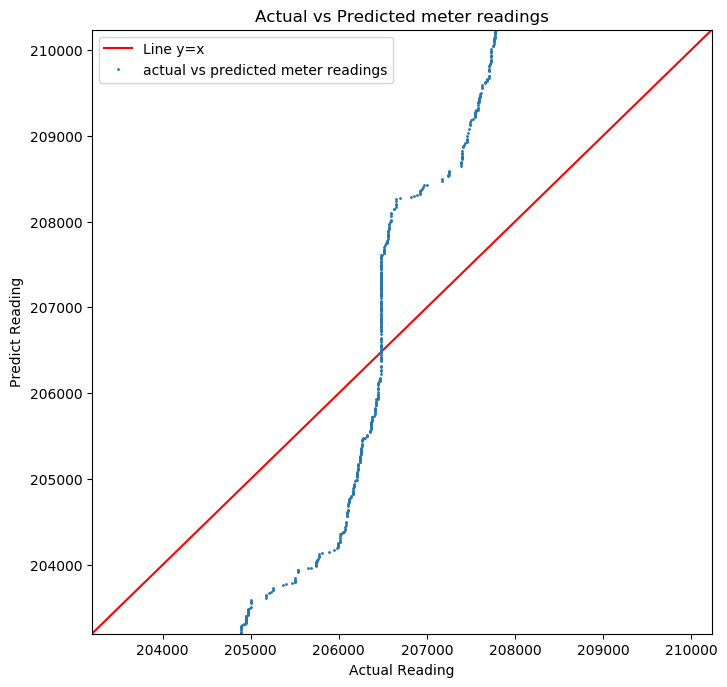

In [11]:
LR_Method1(2233)

+ **Method 2: use the reading of the previous hour as the reading of this hour**

In [12]:
def get_value_ID_L2(ID):
    df1 = pd.DataFrame(columns=['index','value'])
    X = df.groupby(['dataid'])
    values = X.get_group(ID).reset_index()
    values['index'] = (pd.to_datetime(values['localminute']) - pd.to_datetime('2015-10-1')) / pd.Timedelta(hours=1)
    values['index'] = values['index'].round(0).astype(int)
    last_value = values['meter_value'][0]
    sizeindex = round(len(values)*0.7)
    train_size = values['index'][sizeindex]
    for i in range(4392):
        value = 0
        i_rows = values[values['index'] == i].reset_index()
        if len(i_rows) > 0:
            row = i_rows.iloc[0]
            value = row['meter_value']
        else:
            if i>train_size :
                continue
            value = last_value
        df1 = df1.append({'index':i,'value':value},ignore_index=True)
        last_value = value
    
    return df1,train_size

In [13]:
values_hourly_dict_L2 = {} #Store the hourly reading of every meterID below
train_size_dict_L2 = {} #Store the hourly reading of every meterID below
meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
for key in meter_IDs:
    values_hourly,train_size = get_value_ID_L2(key)
    values_hourly_dict_L2[key] = values_hourly
    train_size_dict_L2[key] = train_size

In [14]:
def get_meanScore_of_LR_M2():
    scorelist = []
    score_all= 0
    #  4874,8703,9620 have incomplete training or test set, the score of 4671 cannot be computed
    meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
    for key in meter_IDs:
        values_hourly = values_hourly_dict_L2.get(key)
        train_index = train_size_dict_L2.get(key)
        X_all = values_hourly['index'].values.reshape(-1, 1)
        y_all = values_hourly['value'].values.reshape(-1, 1)

        train_set = values_hourly[values_hourly['index'] < train_index]
        test_set = values_hourly[values_hourly['index'] >= train_index]
        X_train = train_set['index'].values.reshape(-1, 1)
        y_train = train_set['value'].values.reshape(-1, 1)
        X_test = test_set['index'].values.reshape(-1, 1)
        y_test = test_set['value'].values.reshape(-1, 1)
        Linreg = LinearRegression().fit(X_train, y_train)
        score = Linreg.score(X_test, y_test)
        score_all = score_all + score
        scorelist.append(round(score,4))
    score_mean = round(score_all / len(meter_IDs),4)
#     print('LR M2 Score_Mean is:'+ str(score_mean)+', ScoreList is: ',scorelist,'\n')
    print('LR M2 Score_Mean is: %.4f, score list: %s'%(score_mean,scorelist))
    return score_mean

In [15]:
get_meanScore_of_LR_M2()

LR M2 Score_Mean is: -22.2034, score list: [-16.1568, -84.9306, -9.8135, -14.9594, -0.7714, -37.7553, -9.7544, -18.0546, -0.4408, -23.8963, -23.3689, 0.0109, -48.7536]


-22.2034

In [16]:
def LR_Method2(ID):
    values_hourly = values_hourly_dict_L2.get(ID)
    train_index = train_size_dict_L2.get(ID)
    X_all = values_hourly['index'].values.reshape(-1, 1)
    y_all = values_hourly['value'].values.reshape(-1, 1)
    

    train_set = values_hourly[values_hourly['index'] < train_index]
    test_set = values_hourly[values_hourly['index'] >= train_index]
    X_train = train_set['index'].values.reshape(-1, 1)
    y_train = train_set['value'].values.reshape(-1, 1)
    X_test = test_set['index'].values.reshape(-1, 1)
    y_test = test_set['value'].values.reshape(-1, 1)
    Linreg = LinearRegression().fit(X_train, y_train)
    y_predict = Linreg.predict(X_test)

    # Time series plot of the actual and predicted hourly meter readings
    plt.rcParams['figure.figsize'] = (20.0, 6.0)
    plt.plot(X_all, Linreg.predict(X_all),color='r')
    plt.axvline(X_train[-1], color='black', linestyle='--')
    plt.scatter(X_train, y_train, color='b', s=2)
    plt.scatter(X_test, y_test, color='g', s=2)
    plt.title("Meter ID {} LinearRegression Predict Value and Actual Hourly Reading".format(ID))
    plt.tight_layout()
    plt.legend(["LR Fitting Line", "Boundary of Train set and test set", 'train data', 'test data'])
    plt.show()
    
    #  Scatter plot of actual vs predicted meter readings
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    left_interval = min(y_test[0], y_predict[0])[0]
    right_interval = max(y_test[-1], y_predict[-1])[0]
    plt.axis([left_interval, right_interval, left_interval, right_interval])
    plt.plot(range(int(right_interval)), range(int(right_interval)),color='r') # 45 degree line
    plt.plot(y_test, y_predict,'o',markersize=1) # X-axis is actual value
    plt.legend(["Line y=x", "actual vs predicted meter readings"])
    plt.xlabel('Actual Reading')
    plt.ylabel('Predict Reading')
    plt.title('Actual vs Predicted meter readings')
    plt.show()

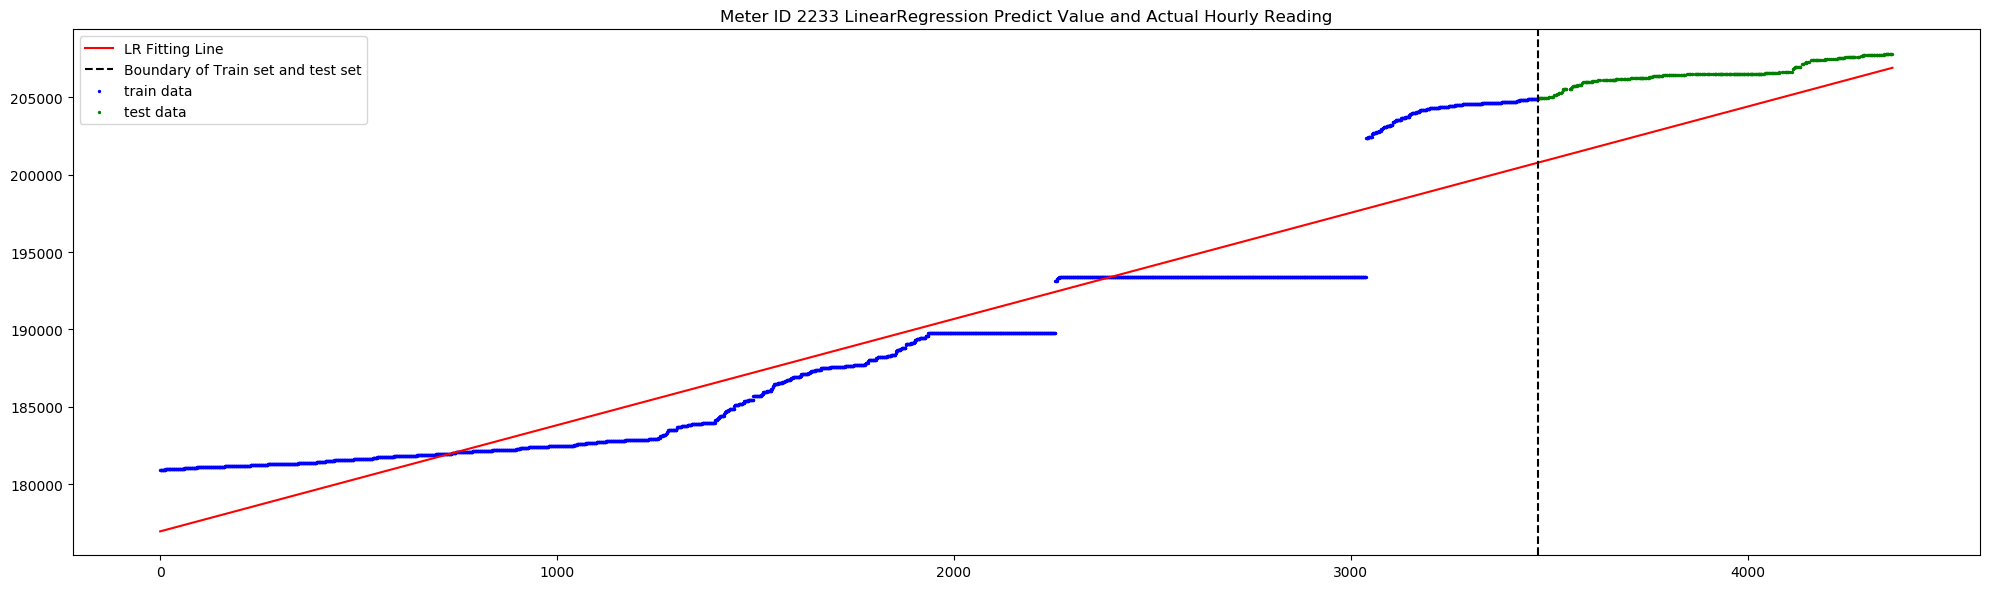

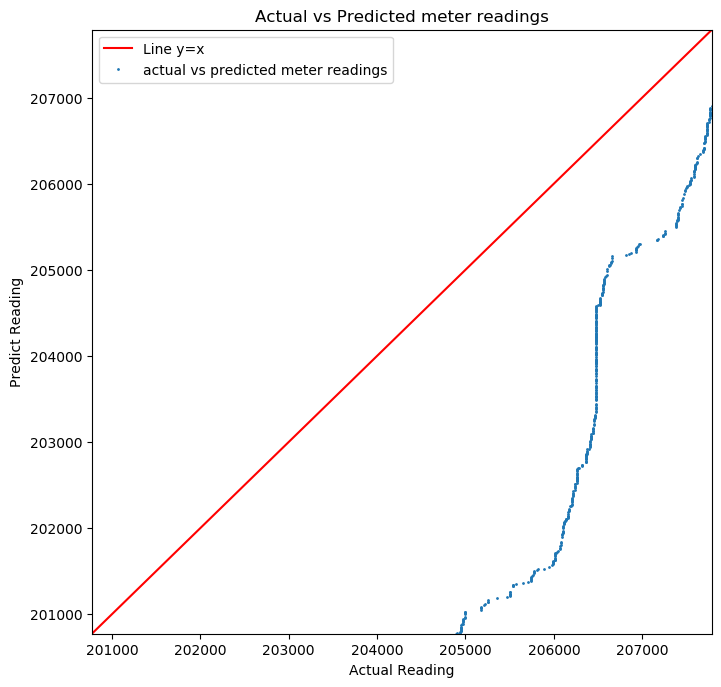

In [17]:
LR_Method2(2233)

+ **Method 3: use the average reading as the reading of this hour**  

   Instead of calculating the mean values one by one, we found out that all the mean values are in the line of the two endpoints of a      gap. Therefore, we can add the average reading by just add the values of the line.

In [18]:
def MeanCompleter(ID):
    df1 = get_value_ID(ID)
    d = dict()
    for i in df1.index:
        d.update({datetime.datetime.strptime(df1['time'][i],'%Y-%m-%d-%H'):df1['value'][i]})
    
    key = list(d.keys())
    internal = pd.DataFrame(key).diff()
    endtime_idx = np.where(internal > pd.Timedelta(hours=1))[0]
    begintime_idx = np.where(internal > pd.Timedelta(hours=1))[0]-1 # Find the locations of gaps
    for i in range(len(begintime_idx)):
        X = list(pd.date_range(start = key[int(begintime_idx[i])],end = key[int(endtime_idx[i])],freq = 'H'))
        for j in range(1,len(X)):
            x1 = 0
            x2 = len(X)
            y1 = d[key[int(begintime_idx[i])]]
            y2 = d[key[int(endtime_idx[i])]]
            k = (y2 - y1)/x2
            b = y1
            y = round(k * j + b,0) # Find the line between two isolated points, which will complete the gap by mean values
            d.update({X[j]:y}) 
    d = sorted(d.items(),reverse=False)
    
    readings = dict()
    for i in range(len(d)):
        readings.update({d[i][0]:d[i][1]})
    return readings

In [19]:
def LR_Method3(ID): 
    # Normalize the input
    readings = MeanCompleter(ID)
    x = list(readings.keys())
    X = []
    for i in range(len(x)):
        X.append(i)
    X = np.array(X).reshape(-1, 1)
    Y = list(readings.values())
    
    # Linear regression training and prediction
    (X_train,X_test,Y_train,Y_test)=train_test_split(X, Y, test_size=0.3,shuffle=False)
    reg = LinearRegression().fit(X_train,Y_train)
    y_pred=reg.predict(X)
    print('The score of LR Method3 is: {0:0.4f}'.format(r2_score(Y,y_pred)))
    split = round(len(X) * 0.7,0)
    
    # Time series plot of the actual and predicted readings for Linear Regression
    plt.rcParams['figure.figsize']=(20,4)
    plt.scatter(X, y_pred,color='b',s=2)
    plt.axvline(split, color='black', linestyle='--')
    plt.scatter(X,Y,color='r',s=2)
    plt.xlabel('Time')
    plt.ylabel('Reading')
    plt.legend(['Train Test Split Line','Linear Regression','Actual Reading'])
    plt.title('Linear regression comparison between actual and predicted readings for ID {}'.format(ID))
    plt.show()
    
    # Scatter plot of actual and predicted readings for Linear Regression
    plt.rcParams['figure.figsize']=(8,8)
    plt.scatter(Y, y_pred,color='b',s=2)
    plt.plot(y_pred,y_pred,color='r')
    plt.xlabel('Actual Reading')
    plt.ylabel('Predicted Reading')
    plt.legend(['45 degrees line','Readings'])
    plt.title('Linear regression scatter Plot for ID {}'.format(ID))
    plt.show()

The score of LR Method3 is: 0.9563


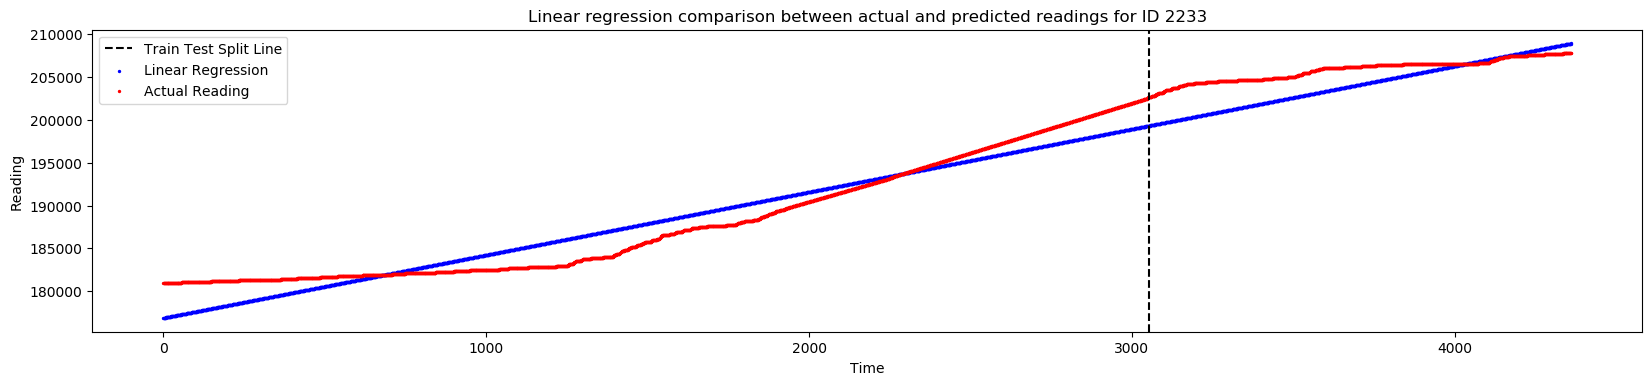

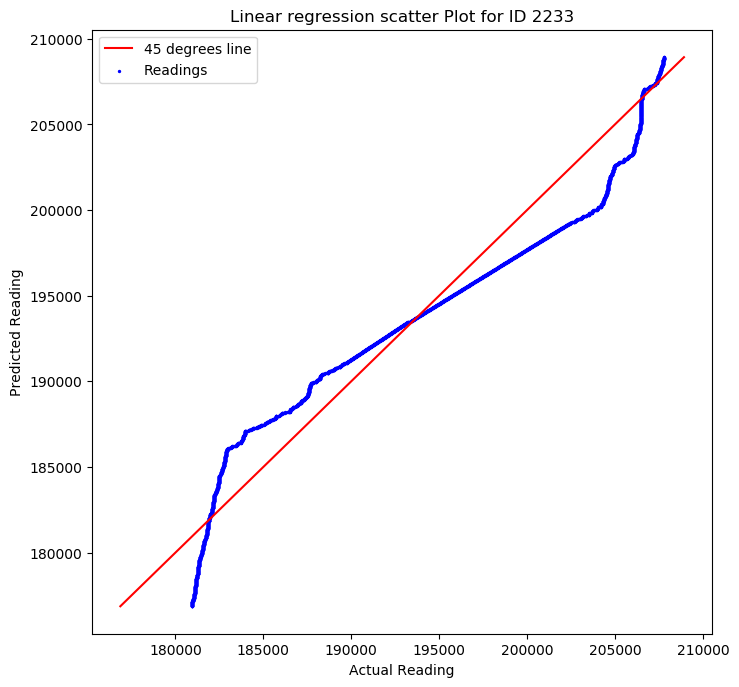

In [20]:
LR_Method3(2233)

In [21]:
def get_meanScore_of_LR_M3():
    scorelist = []
    score_all= 0
    #  4874,8703,9620 have incomplete training or test set, the score of 4671 cannot be computed
    meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
    for key in meter_IDs:
        readings = MeanCompleter(key)
        x = list(readings.keys())
        X = []
        for i in range(len(x)):
            X.append(i)
        X = np.array(X).reshape(-1, 1)
        Y = list(readings.values())
    
        # Linear regression training and prediction
        (X_train,X_test,Y_train,Y_test)=train_test_split(X, Y, test_size=0.3,shuffle=False)
        reg = LinearRegression().fit(X_train,Y_train)
        y_pred=reg.predict(X)
        score = r2_score(Y,y_pred)
        score_all = score_all + score
        scorelist.append(round(score,4))
    score_mean = round(score_all / len(meter_IDs),4)
    print('LR M3 Score_Mean is: %.4f, score list: %s'%(score_mean,scorelist))
    return score_mean

In [22]:
get_meanScore_of_LR_M3()

LR M3 Score_Mean is: 0.9583, score list: [0.9563, 0.9459, 0.9482, 0.9581, 0.9373, 0.9611, 0.9799, 0.9598, 0.9766, 0.9547, 0.9674, 0.9701, 0.9427]


0.9583

+ **The conclusion of Linear Regression**  

   By comparing the average results of the three methods, we found the result of method 3 is the best in dealing with long pieces data missing.

---

## <font color=##008B8B > Question 2.3</font>

**<font color=##008B8B >Do the same as Question 2.2 above but use support vector regression (SVR).</font>**

### 2.3.1 Normal Meters

+ **Use linear regression to predict the future readings.**

In [23]:
def value_prediction_svr(ID,test_size,C=100,kernel='linear',epsilon=0.2):
    
    '''
    Purpose: 
        - Using support vector regression to predict the readings.
        - Plot the actual and predicted readings in time series
        - Plot the true vs predicted scatter readings.
    
    Parameters:
        - ID: The user you would like to evaluate.
        - test_size: The proportion of test set.
        - C: default: 100
        - kernel: default: linear
        - epsilon: default: 0.2
    
    '''
    
    df1=get_value_ID(ID)
    X=DataFrame(df1.index)
    date=df1["time"]
    y=df1["value"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False) # Set shuffle=False. Train:Test=7:3
    split_date=df1["time"][len(X_train)-1] # Train test split date
    ymin=df1["value"].min()
    ymax=df1["value"].max()
    
    model = SVR(C=10,kernel=kernel, epsilon=0.2).fit(X_train,y_train)
    y_pred = model.predict(X)
    score_train=model.score(X_train,y_train)
    score_test=model.score(X_test,y_test)
    print('Coefficient of determination of the training set is',score_train)
    print('Coefficient of determination of the test set is',score_test)
    
    # Plot the true and predicted readings in time series
    plt.rcParams['figure.figsize']=(20,5)
    plt.rcParams['savefig.dpi']=200
    plt.rcParams['figure.dpi']=200
    ax=plt.gca()
    x_major_locator=MultipleLocator(len(X)/10)
    ax.xaxis.set_major_locator(x_major_locator)
    plt.plot(X.values.tolist(), y,'o',markersize=1) # Don't use scatter, otherwise it won't show a complete figure when plotted with 'plt.plot' 
    plt.plot(date, y_pred,'o',markersize=1,c='#ff7f0e')
    plt.vlines(split_date,ymin,ymax,linestyles="dotted",color="k") # Split line
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title("True and Predicted Meter Readings in time series (SVR)")
    plt.savefig("True and Predicted Meter Readings in time series (SVR).jpg")
    plt.show()
    
    # Plot the true vs predicted readings
    plt.rcParams['figure.figsize']=(10,10)
    plt.rcParams['savefig.dpi']=100
    plt.rcParams['figure.dpi']=100
    plt.plot(y,y_pred,'o',markersize=1,label='True vs Predicted')
    plt.plot(y,y,markersize=1,c='#ff7f0e',label='Reference Line')
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title('True vs Predicted Meter Readings (SVR)')
    plt.savefig("True vs Predicted Meter Readings (SVR).jpg")
    plt.legend()
    plt.show()

Coefficient of determination of the training set is 0.9484372514190111
Coefficient of determination of the test set is -4.512855113985448


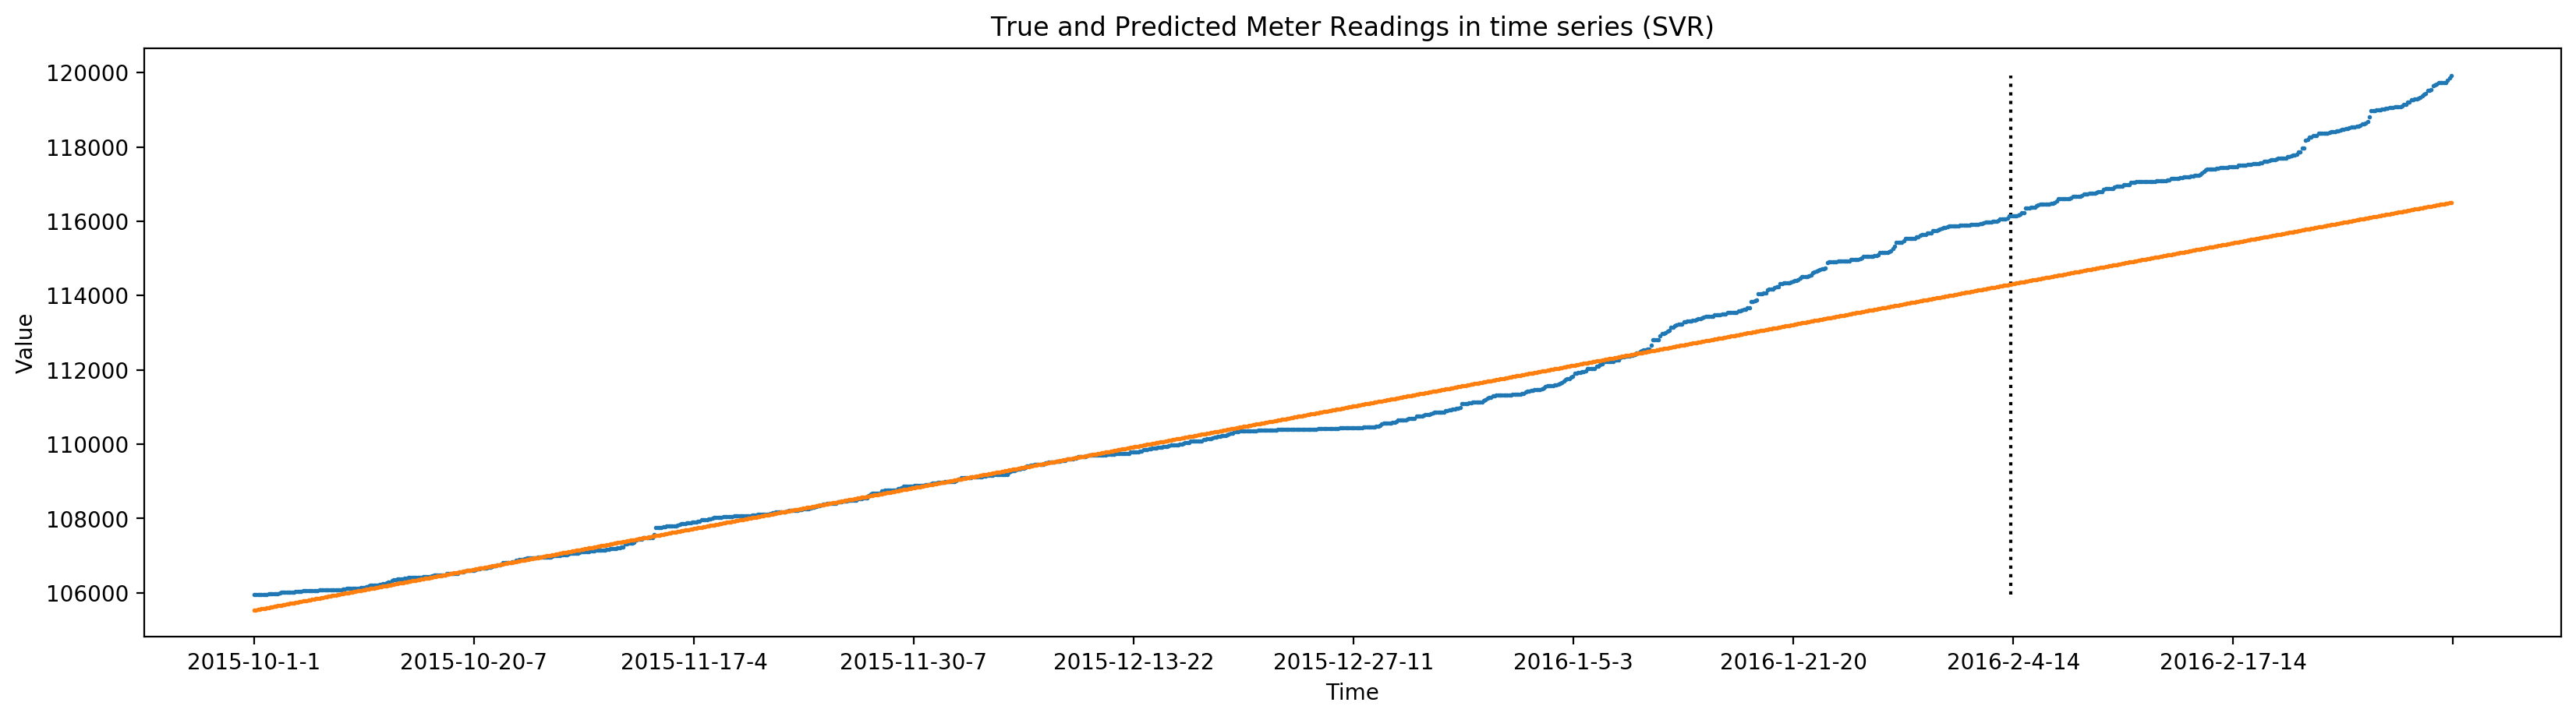

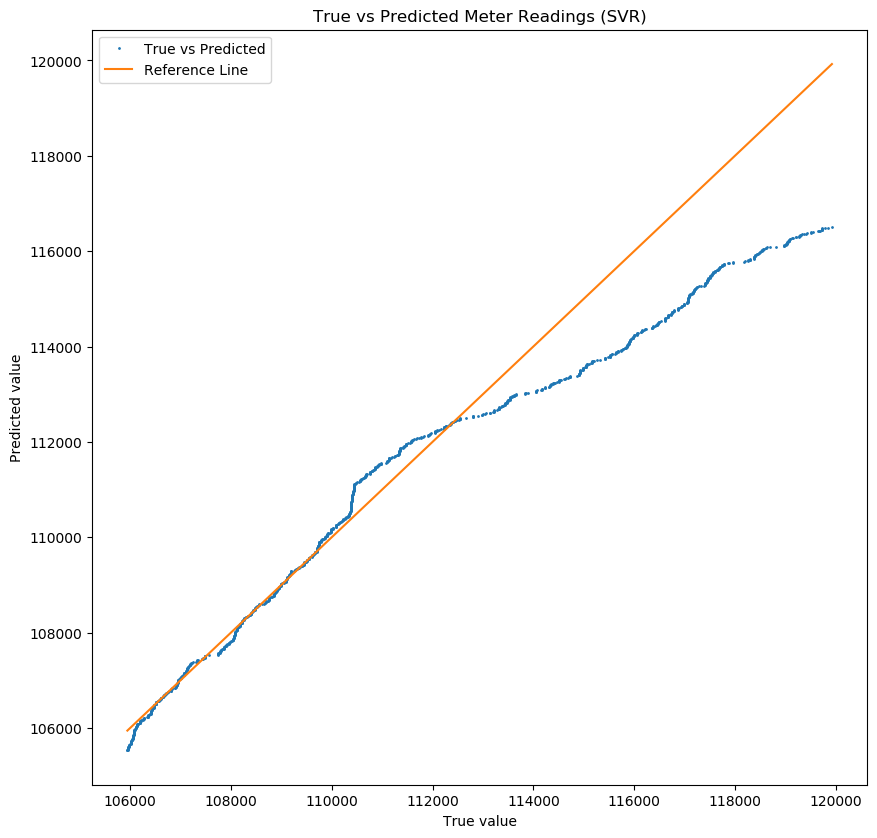

In [24]:
value_prediction_svr(9982,0.2)

### 2.3.2 Long interval meters
Just like 2.2.2.

+ **Method 1: Do not add data**  

   Traverse the combinations of kernel type and C to find the best paramters of SVR.

In [25]:
# Ker_type=‘linear’,‘poly’,‘rbf’

def get_meanScore_of_SVR(Ker_type, c):
    scorelist = []
    score_all= 0
    #  4874,8703,9620 have incomplete training or test sample, the score of 4671 cannot be computed
    meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
    for key in meter_IDs:
        values_hourly = values_hourly_dict1.get(key)
        values_hourly['index'] = (pd.to_datetime(values_hourly['time'], format='%Y-%m-%d-%H') - pd.to_datetime('2015-10-1')) / pd.Timedelta(hours=1)
        X = values_hourly['index'].values.reshape(-1, 1)
        y = values_hourly['value'].values.reshape(-1, 1)
        # Set shuffle=False. Train:Test=7:3
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        svr = SVR(kernel=Ker_type,gamma='scale',C=c).fit(X_train, y_train)
        score = svr.score(X_test, y_test)
        score_all = score_all + score
        scorelist.append(round(score,4))
    score_mean = round ( score_all / len(meter_IDs),4)
#     print('Ker_type is :'+ str(Ker_type)+', c is :'+ str(c)+', Score_Mean is:'+ str(score_mean)+', ScoreList is: ',scorelist,'\n')
    print('Kernel type is: %s, c is: %.4f, score mean is: %.4f, score list: %s'%(Ker_type,c,score_mean,scorelist))
    return score_mean

Kernel type is: linear, c is: 1.0000, score mean is: -26.4943, score list: [-23.4329, -71.3604, -170.3665, -2.0669, -1.3483, -6.0327, 0.3688, -2.0973, -0.7064, -20.0556, -3.3474, 0.4042, -44.3847]
Kernel type is: poly, c is: 100.0000, score mean is: -308.7142, score list: [-530.4769, -308.4733, -2039.2259, -155.7347, -0.0279, -274.5348, -73.537, -25.8193, -132.0301, -84.4342, -199.9383, -80.1654, -108.8867]
Kernel type is: poly, c is: 1000.0000, score mean is: -308.7165, score list: [-530.3759, -308.4157, -2039.2667, -155.7609, -0.0283, -274.5104, -73.5144, -25.8856, -131.9844, -84.432, -200.0945, -80.1684, -108.8773]
Kernel type is: poly, c is: 5000.0000, score mean is: -308.6561, score list: [-529.9264, -308.0184, -2039.448, -155.8773, -0.0299, -274.402, -73.4143, -26.1817, -131.7814, -84.4223, -200.0115, -80.1814, -108.8354]
Kernel type is: poly, c is: 10000.0000, score mean is: -308.6587, score list: [-529.3639, -307.4724, -2039.6746, -156.0229, -0.0319, -274.2613, -73.2892, -26.55

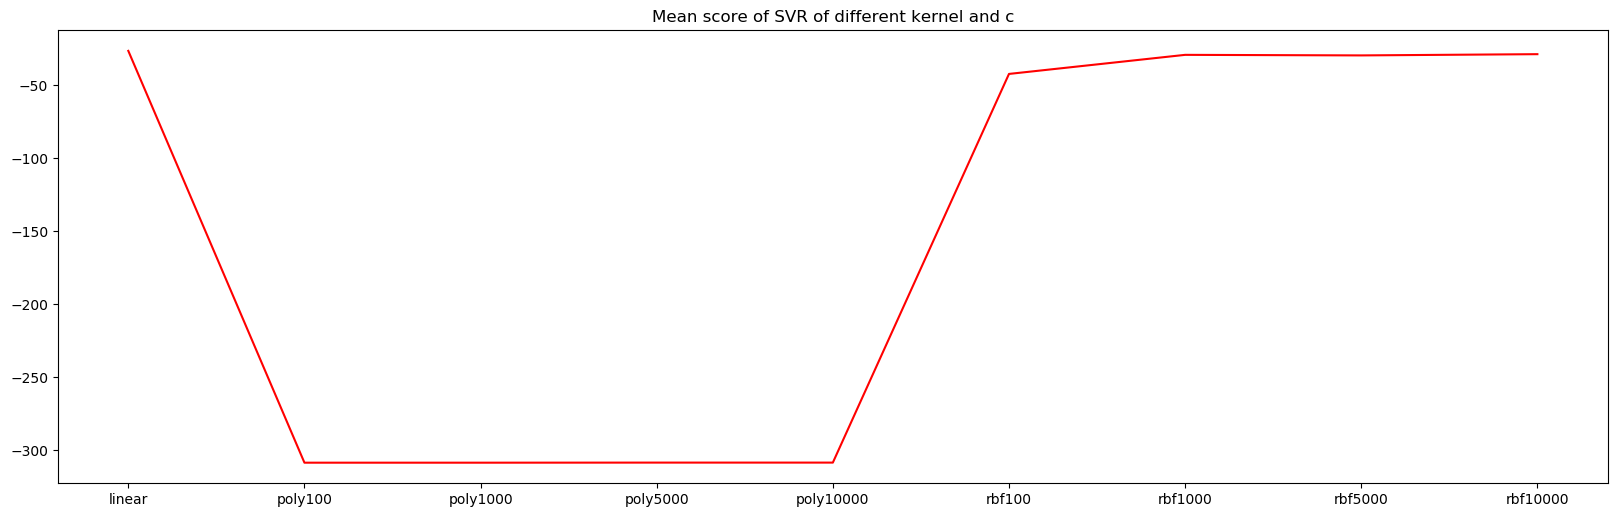

In [26]:
scores_by_degree = []
x_label = []
score = get_meanScore_of_SVR('linear',1)
scores_by_degree.append(score)
x_label.append('linear')

for type in ['poly', 'rbf']:
    for c in [100, 1000, 5000, 10000]:
        score = get_meanScore_of_SVR(type, c)
        scores_by_degree.append(score)
        x_label.append(type+str(c))
    
plt.rcParams['figure.figsize'] = (20.0, 6.0)
plt.plot(x_label, scores_by_degree,color='r')
plt.title("Mean score of SVR of different kernel and c")
plt.show()

**We can see that the best score is reached when the kernel is linear and c=1, so we will use linear SVR to fit the data.**

In [27]:
def SVR_Method1(ID):
    values_hourly = get_value_ID(ID)
    values_hourly['index'] = (pd.to_datetime(values_hourly['time'], format='%Y-%m-%d-%H') - pd.to_datetime('2015-10-1')) / pd.Timedelta(hours=1)
    X_all = values_hourly['index'].values.reshape(-1, 1)
    y_all = values_hourly['value'].values.reshape(-1, 1)
    # Set shuffle=False. Train:Test=7:3
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, shuffle=False)
    svr = SVR(kernel='linear',gamma='scale',C=1).fit(X_train, y_train)
    y_predict = svr.predict(X_test)

    # Time series plot of the actual and predicted hourly meter readings
    plt.rcParams['figure.figsize'] = (20.0, 6.0)
    plt.plot(X_all, svr.predict(X_all),color='r')
    plt.axvline(X_train[-1], color='black', linestyle='--')
    plt.scatter(X_train, y_train, color='b', s=2)
    plt.scatter(X_test, y_test, color='g', s=2)
    plt.title("Meter ID {} SVR Predict Value and Actual Hourly Reading".format(ID))
    plt.tight_layout()
    plt.legend(["SVR Fitting Line", "Boundary of Train set and test set", 'train data', 'test data'])
    plt.show()
    
    #  Scatter plot of actual vs predicted meter readings
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    left_interval = min(y_test[0], y_predict[0])
    right_interval = max(y_test[-1], y_predict[-1])[0]
    plt.axis([left_interval, right_interval, left_interval, right_interval])
    plt.plot(range(int(right_interval)), range(int(right_interval)),color='r') # 45 degree line
    plt.plot(y_test, y_predict,'o',markersize=1) # X-axis is actual value
    plt.legend(["Line y=x", "actual vs predicted meter readings"])
    plt.xlabel('Actual Reading')
    plt.ylabel('Predict Reading')
    plt.title('Actual vs Predicted meter readings')
    plt.show()

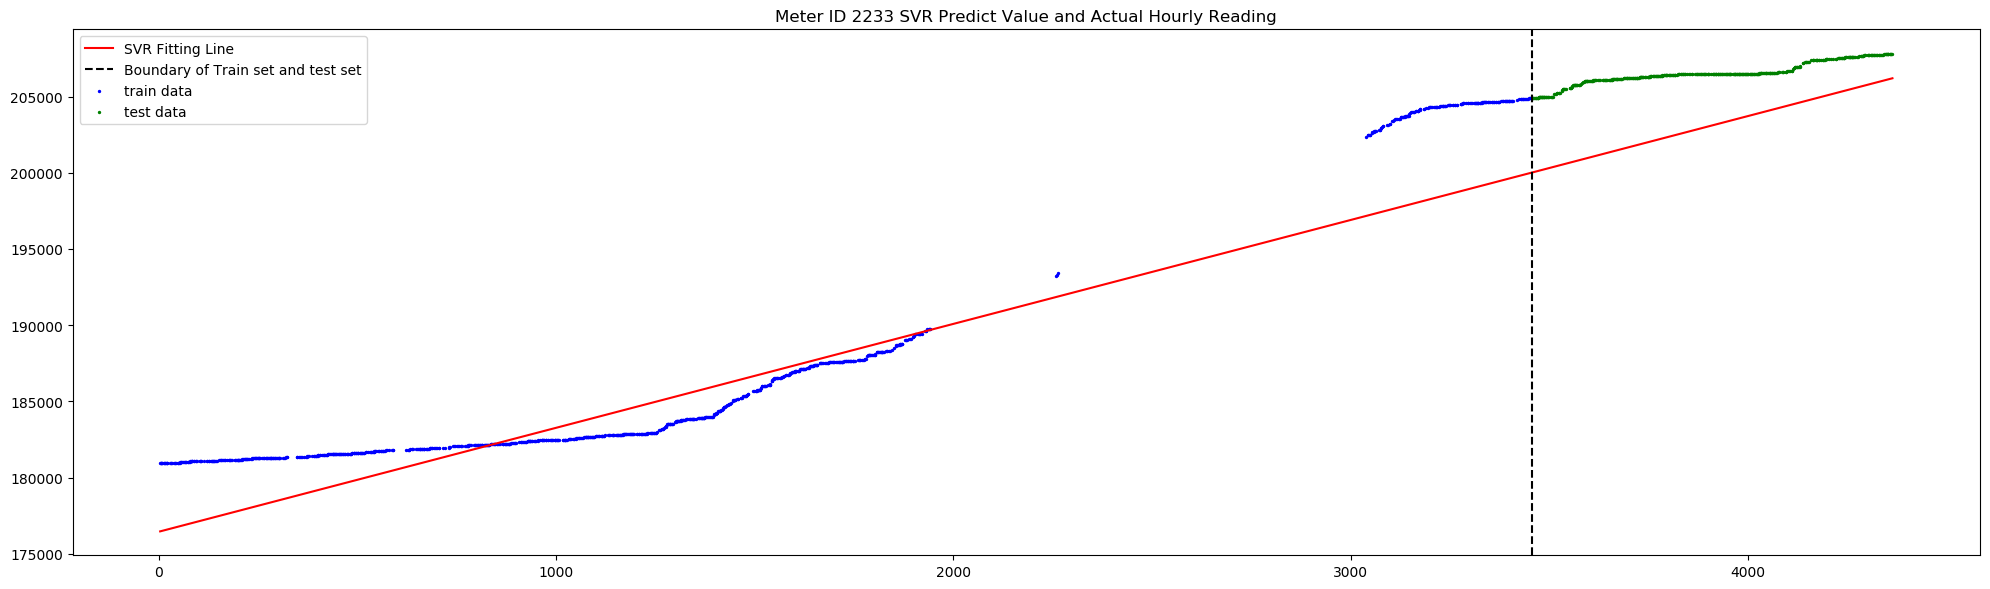

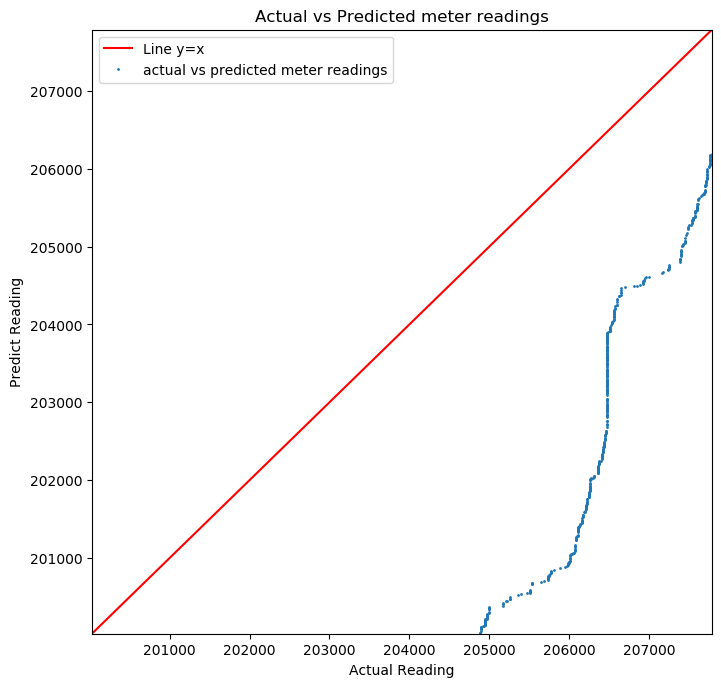

In [28]:
SVR_Method1(2233)

+ **Method 2: Use the reading of the previous hour as the reading of this hour**

In [29]:
def get_meanScore_of_SVR_M2():
    scorelist = []
    score_all= 0
    #  4874,8703,9620 have incomplete training or test set, the score of 4671 cannot be computed
    meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
    for key in meter_IDs:
        values_hourly = values_hourly_dict_L2.get(key)
        train_index = train_size_dict_L2.get(key)
        X_all = values_hourly['index'].values.reshape(-1, 1)
        y_all = values_hourly['value'].values.reshape(-1, 1)

        train_set = values_hourly[values_hourly['index'] < train_index]
        test_set = values_hourly[values_hourly['index'] >= train_index]
        X_train = train_set['index'].values.reshape(-1, 1)
        y_train = train_set['value'].values.reshape(-1, 1)
        X_test = test_set['index'].values.reshape(-1, 1)
        y_test = test_set['value'].values.reshape(-1, 1)
        svr = SVR(kernel='linear',gamma='scale',C=1).fit(X_train, y_train)
        score = svr.score(X_test, y_test)
        score_all = score_all + score
        scorelist.append(round(score,4))
    score_mean = score_all / len(meter_IDs)
#     print('SVR M2 Score_Mean is:'+ str(score_mean)+', ScoreList is: ',scorelist,'\n')
    print('SVR M2 Score_Mean is: %s, score list: %s'%(score_mean,scorelist))
    return score_mean

In [30]:
get_meanScore_of_SVR_M2()

SVR M2 Score_Mean is: -40.571485013979185, score list: [-65.6997, -88.4828, -24.5088, -55.5069, -0.8122, -95.6536, -19.2677, -8.5487, -0.4441, -39.5042, -75.1777, 0.8473, -54.6702]


-40.571485013979185

In [31]:
def SVR_Method2(ID):
    values_hourly = values_hourly_dict_L2.get(ID)
    train_index = train_size_dict_L2.get(ID)
    X_all = values_hourly['index'].values.reshape(-1, 1)
    y_all = values_hourly['value'].values.reshape(-1, 1)
    

    train_set = values_hourly[values_hourly['index'] < train_index]
    test_set = values_hourly[values_hourly['index'] >= train_index]
    X_train = train_set['index'].values.reshape(-1, 1)
    y_train = train_set['value'].values.reshape(-1, 1)
    X_test = test_set['index'].values.reshape(-1, 1)
    y_test = test_set['value'].values.reshape(-1, 1)
    svr = SVR(kernel='linear',gamma='scale',C=1).fit(X_train, y_train)
    y_predict = svr.predict(X_test)

    # Time series plot of the actual and predicted hourly meter readings
    plt.rcParams['figure.figsize'] = (20.0, 6.0)
    plt.plot(X_all, svr.predict(X_all),color='r')
    plt.axvline(X_train[-1], color='black', linestyle='--')
    plt.scatter(X_train, y_train, color='b', s=2)
    plt.scatter(X_test, y_test, color='g', s=2)
    plt.title("Meter ID {} SVR Predict Value and Actual Hourly Reading".format(ID))
    plt.tight_layout()
    plt.legend(["SVR Fitting Line", "Boundary of Train set and test set", 'train data', 'test data'])
    plt.show()
    
    #  Scatter plot of actual vs predicted meter readings
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    left_interval = min(y_test[0], y_predict[0])
    right_interval = max(y_test[-1], y_predict[-1])[0]
    plt.axis([left_interval, right_interval, left_interval, right_interval])
    plt.plot(range(int(right_interval)), range(int(right_interval)),color='r') # 45 degree line
    plt.plot(y_test, y_predict,'o',markersize=1) # X-axis is actual value
    plt.legend(["Line y=x", "actual vs predicted meter readings"])
    plt.xlabel('Actual Reading')
    plt.ylabel('Predict Reading')
    plt.title('Actual vs Predicted meter readings')
    plt.show()

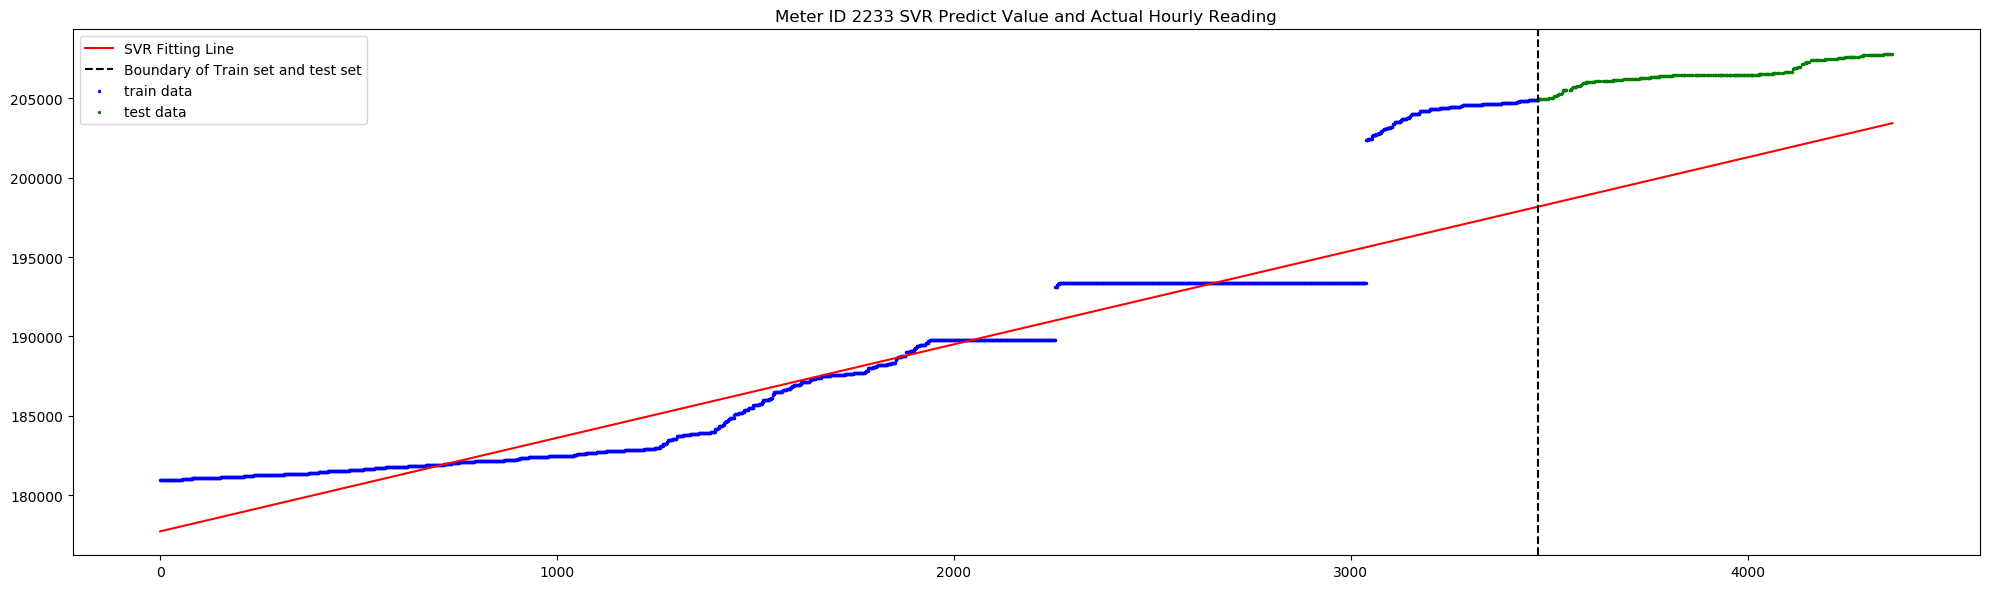

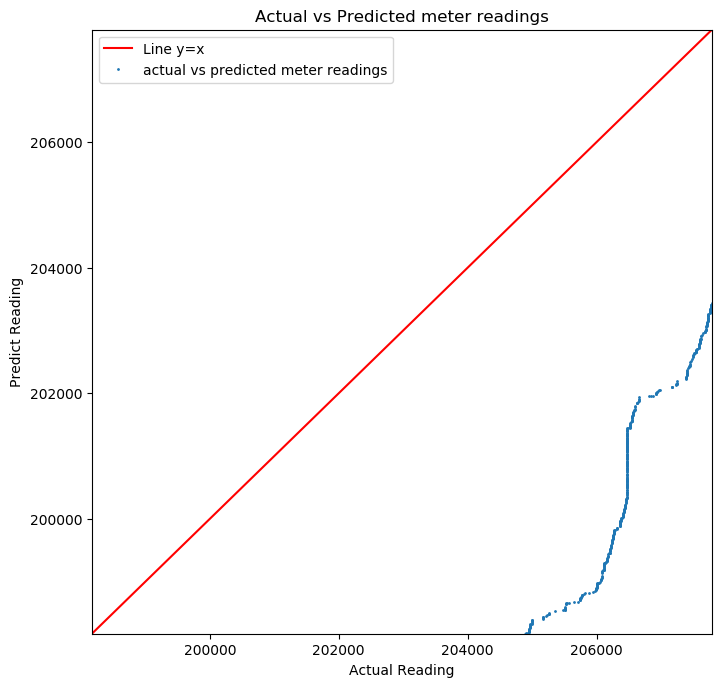

In [32]:
SVR_Method2(2233)

+ **Method 3: Use the average reading as the reading of this hour**

   There are many different kernels and parameters in SVR. In this question, we selected three kernels: linear, rbf, poly and different    C(1,10,100,1000). We used the goodness of fit $R^{2}$ score as the metric for regression. Then we can find which kernel has the        maximum $R^{2}$ score and apply this kernel to predict the future meter readings.

In [33]:
def SVR_Method3_R2_score(ID,KERNEL,penalty): # Calculate the R2 score for different kernels
    readings = MeanCompleter(ID)
    x = list(readings.keys())
    X = []
    for i in range(len(x)):
        X.append(i)
    X = np.array(X).reshape(-1, 1)
    Y = list(readings.values())
    
    (X_train,X_test,Y_train,Y_test)=train_test_split(X, Y, test_size=0.1,shuffle=False)
    svr = SVR(kernel=KERNEL,gamma='scale',C=penalty,max_iter=10000).fit(X_train, Y_train)
    y_pred = svr.predict(X)
    r2 = round(r2_score(Y,y_pred),4)
    print('The R2 for {} kernel with C = {} is: {}'.format(KERNEL,penalty,r2))
    return r2,KERNEL,penalty

In [34]:
def SVR_best_performance(ID): # Find the kernel which has the largest R2 score
    KERNEL = ['linear','rbf','poly']
    penalty = [1,10,100,1000]
    k = dict()
    for i in range(len(KERNEL)):
        for j in range(len(penalty)):
            r2,ker,pen = SVR_Method3_R2_score(ID,KERNEL[i],penalty[j])
            k.update({(ker,pen):r2})
    best = max(k,key=k.get) 
    print('{} kernel achieved the best performance for ID {} with C = {}'.format(best[0],ID,best[1]))
    return best

In [35]:
def SVR_Method3(ID): 
    best = SVR_best_performance(ID)
    readings = MeanCompleter(ID)
    
    # Normalize the input
    x = list(readings.keys())
    X = []
    for i in range(len(x)):
        X.append(i)
    X = np.array(X).reshape(-1, 1)
    Y = list(readings.values())
    
    # SVR training and prediction
    (X_train,X_test,Y_train,Y_test)=train_test_split(X, Y, test_size=0.3,shuffle=False)
    svr = SVR(kernel=best[0],gamma='scale',C=best[1],max_iter=10000).fit(X_train, Y_train)
    y_pred = svr.predict(X)  
    split = round(len(X) * 0.7,0)
    
    # Time series plot of the actual and predicted readings for SVR
    plt.rcParams['figure.figsize']=(20,4)
    plt.scatter(X,Y,color='r',s=2)
    plt.scatter(X, y_pred,color='b',s=2)
    plt.axvline(split, color='black', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Reading')
    plt.legend(['Train Test Split Line','Actual Reading','SVR'])
    plt.title('SVR comparison between actual and predicted readings for ID {}'.format(ID))
    plt.show()
    
    # Scatter plot of actual and predicted readings for SVR
    plt.rcParams['figure.figsize']=(8,8)
    plt.scatter(Y, y_pred,color='b',s=2)
    plt.plot(y_pred,y_pred,color='r')
    plt.xlabel('Actual Reading')
    plt.ylabel('Predicted Reading')
    plt.legend(['45 degrees line','Readings'])
    plt.title('SVR scatter Plot for ID {}'.format(ID))
    plt.show()

The R2 for linear kernel with C = 1 is: -0.0053
The R2 for linear kernel with C = 10 is: 0.9223
The R2 for linear kernel with C = 100 is: -0.2828
The R2 for linear kernel with C = 1000 is: 0.082
The R2 for rbf kernel with C = 1 is: 0.0798
The R2 for rbf kernel with C = 10 is: 0.8909
The R2 for rbf kernel with C = 100 is: 0.9911
The R2 for rbf kernel with C = 1000 is: 0.9981
The R2 for poly kernel with C = 1 is: 0.5627
The R2 for poly kernel with C = 10 is: 0.5371
The R2 for poly kernel with C = 100 is: 0.5337
The R2 for poly kernel with C = 1000 is: 0.0334
rbf kernel achieved the best performance for ID 2233 with C = 1000


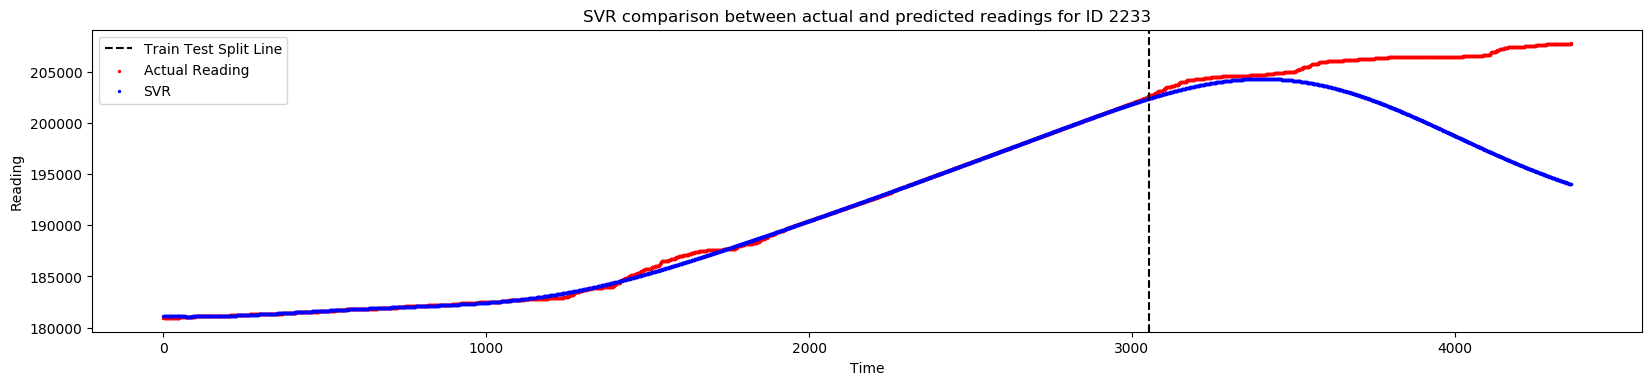

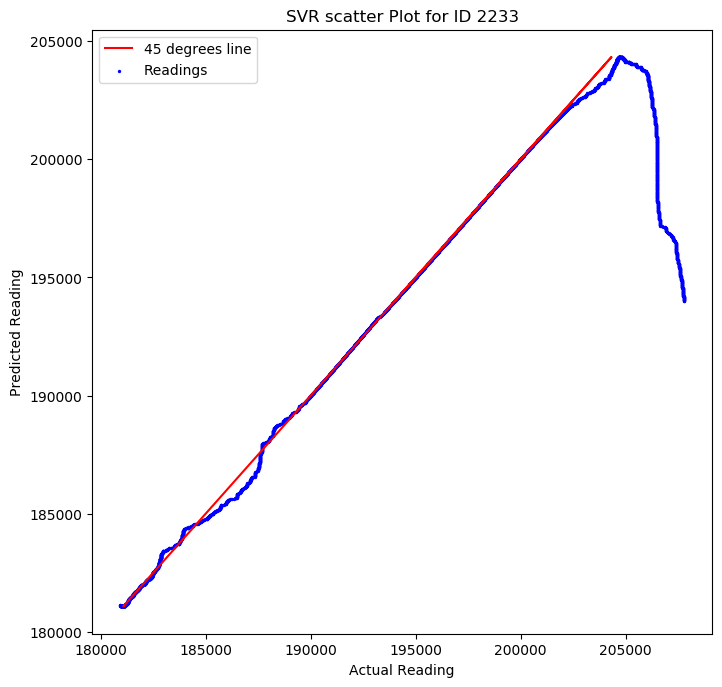

In [36]:
SVR_Method3(2233)

In [37]:
def get_meanScore_of_SVR_M3():
    scorelist = []
    score_all= 0
    #  4874,8703,9620 have incomplete training or test set, the score of 4671 cannot be computed
    meter_IDs = [2233, 2638, 2645, 3039, 4352, 4421, 4447, 6685, 6863,7460, 7919, 8467, 9474]
    for key in meter_IDs:
        readings = MeanCompleter(key)
        x = list(readings.keys())
        X = []
        for i in range(len(x)):
            X.append(i)
        X = np.array(X).reshape(-1, 1)
        Y = list(readings.values())
    
        # Linear regression training and prediction
        (X_train,X_test,Y_train,Y_test)=train_test_split(X, Y, test_size=0.3,shuffle=False)
        svr = SVR(kernel='rbf',gamma='scale',C=1000,max_iter=10000).fit(X_train, Y_train)
        y_pred = svr.predict(X)
        score = r2_score(Y,y_pred)
        score_all = score_all + score
        scorelist.append(round(score,4))
    score_mean = score_all / len(meter_IDs)
    print('SVR M3 Score_Mean is: %s, score list: %s'%(score_mean,scorelist))
    return score_mean

In [38]:
get_meanScore_of_SVR_M3()

SVR M3 Score_Mean is: 0.8270280315892856, score list: [0.8704, 0.8816, 0.894, 0.8602, 0.8872, 0.867, 0.8409, 0.7229, 0.5898, 0.7972, 0.8336, 0.861, 0.8456]


0.8270280315892856

+ **The conclusion of Support Vector Regression**  

   By comparing the average results of the three methods, method 3 is the best in dealing with data that have long missing pieces, which is the same result as linear regression.